# ECG MAE walk_through

In [40]:
import sys

sys.path.append("..")

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection
from models.mini_mae_v2 import ECGMAE_1D, mae_loss_masked
from data.dataset import SingleNpyECGDataset
from models.mini_mae_v2 import PatchEmbed1D

In [42]:
npy_path = "../data/mitdb_singlelead_500hz_10s.npy"

ds = SingleNpyECGDataset(npy_path, limit=64)
print(f"Dataset length: {len(ds)}")

Dataset length: 64


In [43]:
x = ds[0]  # expected shape [N, L] or [1, L] or [L]
print("Raw ds[0] type:", type(x))
print("Raw ds[0] shape:", x.shape)

Raw ds[0] type: <class 'torch.Tensor'>
Raw ds[0] shape: torch.Size([1, 5000])


## Part 0: Patch / Token

The goal of Part 0 is to convert a continuous ECG signal into a sequence of tokens.

Through `patchify` and `patch embedding`, we obtain representations that preserve temporal structure and are suitable for Transformer-based models.

### Load one ECG segment

In this step, we load one ECG segment from the training `.npy` dataset. The segment is `10 seconds` long with a sampling rate of `500 Hz`, resulting in `5000` samples.

This raw ECG waveform serves as a reference for all later steps. Every patch and token should be traceable back to this original signal.

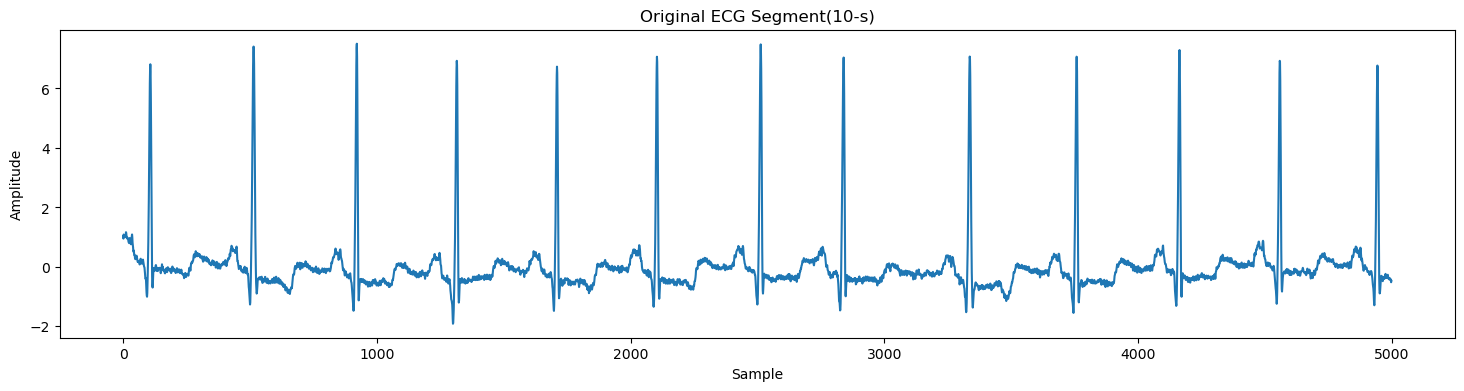

In [44]:
plt.figure(figsize=(18, 4))
plt.plot(x[0].detach().cpu().numpy())
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Original ECG Segment(10-s)")
plt.show()

### Standardize tensor shape to `[B, N, L]`

We standardize the dataset to:
- `B`: batch size (1 here)
- `N`: number of leads (1 here)
- `L`: number of samples (10s @ 500Hz -> 5000)

Final input format: `x_t: [B, N, L]`

This is the expected input format for Part 0 of the model.

In [45]:
N, L = x.shape
x_t = x.unsqueeze(0)  # [B, N, L] with B=1

print("[After standardization]")
print("x (no batch) shape [N, L]:", tuple(x.shape))
print("x_t  (with batch) shape [B, N, L]:", tuple(x_t.shape))

[After standardization]
x (no batch) shape [N, L]: (1, 5000)
x_t  (with batch) shape [B, N, L]: (1, 1, 5000)


### Patchify: split waveform into raw patches (targets)

In this step, we use `patchify()` to split the continuous ECG signal into non-overlapping patches 

Each patch contains `patch_size = 10` consecutive samples. Therefore:

- Total samples: `L = 10s * 500Hz = 5000`
- Number of patches: `T = L / patch_size = 5000 / 10 = 500`
- Input: `[B, N, L]`
- Output: `target_patches: [B, T, N * P]`

`patchify()` does not learn anything, it only splits the waveform

These raw patches are the **ground truth reconstruction targets**.

In [46]:
patch_size = 10
d_model = 128
n_leads = N
T_expected = L // patch_size

print("[Part 0 config]")
print(f"Number of leads N = {N}")
print(f"Sampling points L = {L}")
print(f"Patch size P = {patch_size}")
print(f"Token count T = L/P = {T_expected}")
print(f"Embedding dim D = {d_model}")

[Part 0 config]
Number of leads N = 1
Sampling points L = 5000
Patch size P = 10
Token count T = L/P = 500
Embedding dim D = 128


In [47]:
model = ECGMAE_1D(
    n_leads=1,
    patch_size=10,
    d_model=128,
    enc_depth=4,
    dec_depth=2,
    n_heads=4,
    dim_ff=256,
    dropout=0.1,
    mask_ratio=0.6,
)

In [48]:
# Patchify: split waveform into raw patches (targets)

target_patches = model.patchify(x_t)  # [B, T, N*P]=[1, 500, 1 * 10]

print("[Shapes]")
print("x_t:", tuple(x_t.shape))  # [1, N, L]
print("target_patches:", tuple(target_patches.shape))  # [1, T, N*P]

[Shapes]
x_t: (1, 1, 5000)
target_patches: (1, 500, 10)


### Visualizing raw patches

To better understand what a patch represents, we visualize the output of `patchify()`:

- A 2D image showing the [T, N*P] patch matrix
- Each row corresponds to one patch (raw signal for one token)

We also plot a few example patches as waveforms to confirm that each patch is a contiguous time segment of the ECG.

[patchify()]
tp shape [T, N * P]: (500, 10)


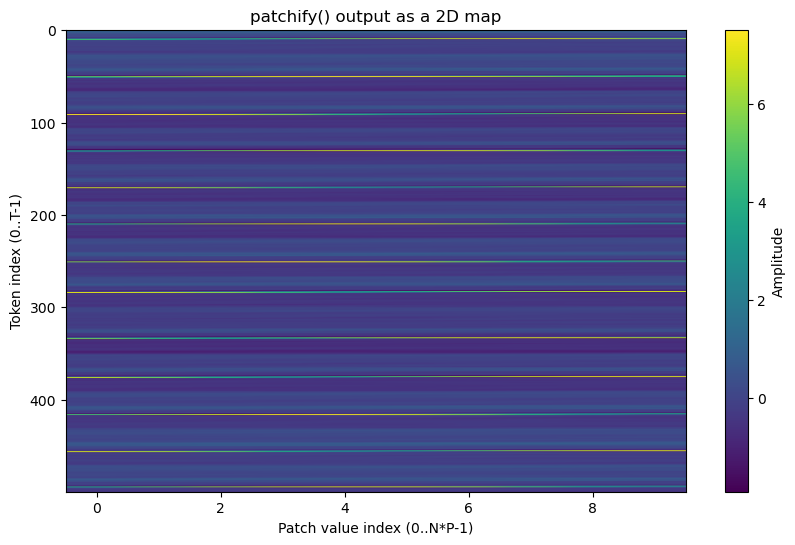

In [49]:
# ====== Visualize `patchify()` output ======
tp = target_patches[0].detach().cpu().numpy()  # [T, N*P]
T = tp.shape[0]
NP = tp.shape[1]

print("[patchify()]")
print("tp shape [T, N * P]:", tp.shape)

plt.figure(figsize=(10, 6))
plt.imshow(tp, aspect="auto")
plt.colorbar(label="Amplitude")
plt.xlabel("Patch value index (0..N*P-1)")
plt.ylabel("Token index (0..T-1)")
plt.title("patchify() output as a 2D map")
plt.show()

This figure visualizes the output of `patchify()` with shape `[T, N*P]`.

- Y-axis (token index): patch index along time
- X-axis (patch value index): sample index inside each patch
- Color: ECG amplitude

In this experiment, a 10-second ECG (5000 samples) is split into `T = 500` non-overlapping patches, each containing `P = 10` consecutive samples.

The purpose of this figure is not to analyze ECG morphology, but to perform structural and implementation-level validation:

- Verify that `patchify()` splits the signal correctly along time
- Ensure that each patch contains consecutive samples
- Confirm that the number of patches matches the expectation (500)
- Quickly detect implementation bugs (e.g., wrong stride, overlapping or shuffled patches)

From this figure, we can confirm that:

- Patches are ordered and contiguous in time
- The amplitude range matches the original ECG
- `patchify()` produces valid reconstruction targets

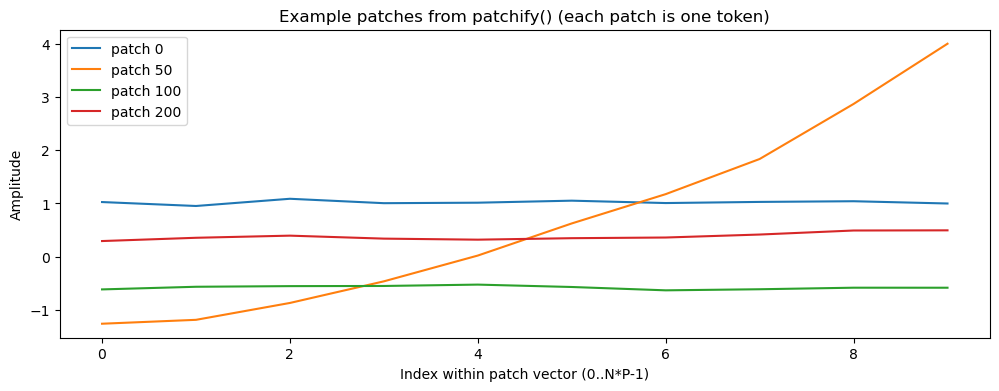

In [50]:
# Plot a few patches (vector form)
idxs = [0, min(50, T - 1), min(100, T - 1), min(200, T - 1)]
plt.figure(figsize=(12, 4))
for i in idxs:
    plt.plot(tp[i], label=f"patch {i}")
plt.xlabel("Index within patch vector (0..N*P-1)")
plt.ylabel("Amplitude")
plt.title("Example patches from patchify() (each patch is one token)")
plt.legend()
plt.show()

This figure shows several example patches extracted from the output of `patchify()`.

- Each patch corresponds to 10 consecutive ECG samples.
- The x-axis represents the index within a patch (0–9), 
- and the y-axis represents ECG amplitude.
- Different colored curves correspond to patches from different time positions (e.g., patch 0, 50, 100, 200).

From this figure, we can confirm that:

- Tokens preserve local waveform information
- Tokens from different time positions show different local shapes and amplitudes
- The patchify operation does not break signal continuity

Thus, this figure illustrates the local physical meaning of a token, not full ECG semantics.

### Patch embedding: from waveform to token

Next, we use `PatchEmbed1D()` to project each raw patch into a D-dimensional embedding

This is implemented using `Conv1d(kernel=P, stride=P)`, which can be intuitively understood as:

> One patch -> One D-dimensional vector

- Input: `[B, N, L]`
- Output: `tokens: [B, T, D]`

From this point on, the model works on a **sequence of feature vectors**, not raw waveforms

In [51]:
# Patch embedding: from waveform to token

patch_embed = PatchEmbed1D(n_leads=n_leads, d_model=d_model, patch_size=patch_size)
tokens = patch_embed(x_t)  # [B, T, D]

print("[Shapes]")
print("x_t:", tuple(x_t.shape))  # [1, N, L]
print("tokens:", tuple(tokens.shape))  # [1, T, D]

[Shapes]
x_t: (1, 1, 5000)
tokens: (1, 500, 128)


### Visualizing token embeddings

To inspect the properties of token embeddings, we visualize them in two ways:

- The L2 norm of each token embedding over time
- A 2D heatmap of the embedding matrix `[T, D]`

These visualizations help illustrate how tokens differ in feature space across time.

[PatchEmbed1D()]
tok shape [T, D]: (500, 128)


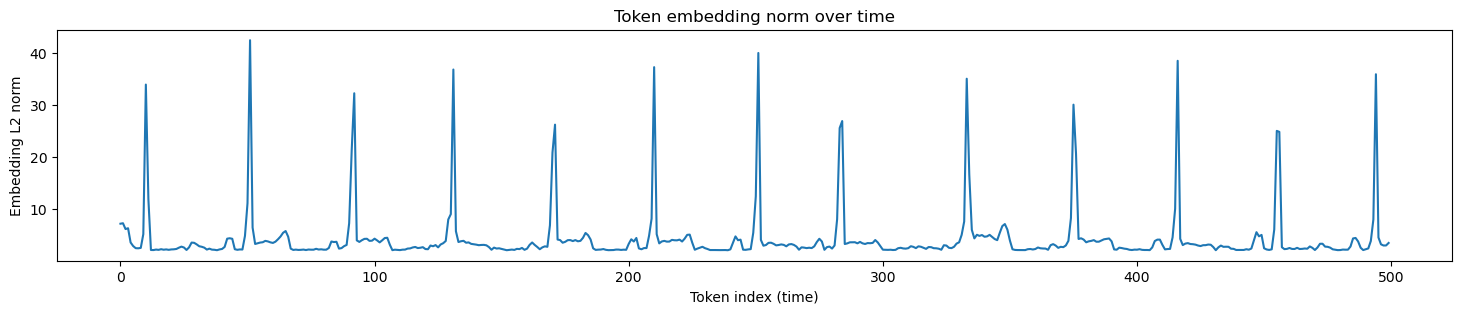

In [52]:
# ====== Visualize `PatchEmbed1D()` output ======
tok = tokens[0].detach().cpu()  # [T, D]
print("[PatchEmbed1D()]")
print("tok shape [T, D]:", tuple(tok.shape))

token_norm = torch.norm(tok, dim=1).numpy()  # [T]

plt.figure(figsize=(18, 3))
plt.plot(token_norm)
plt.xlabel("Token index (time)")
plt.ylabel("Embedding L2 norm")
plt.title("Token embedding norm over time")
plt.show()

This figure shows the `L2 norm` of token embeddings produced by `PatchEmbed1D` as a function of token index (time).

Each point represents the overall magnitude of the embedding vector for one token.

This figure is used to inspect whether the patch embedding stage produces distinguishable representations across time

From this figure, we can observe that:

- The embedding norm varies across tokens
- Clear peaks appear at certain time positions
- These peaks often correspond to segments with stronger signal activity or local changes

However:

- The embedding norm reflects feature magnitude, not semantic meaning
- These peaks should not be directly interpreted as specific ECG events or diagnoses

Thus, this figure shows that patch embeddings respond to signal variation, but do not yet encode high-level semantics.

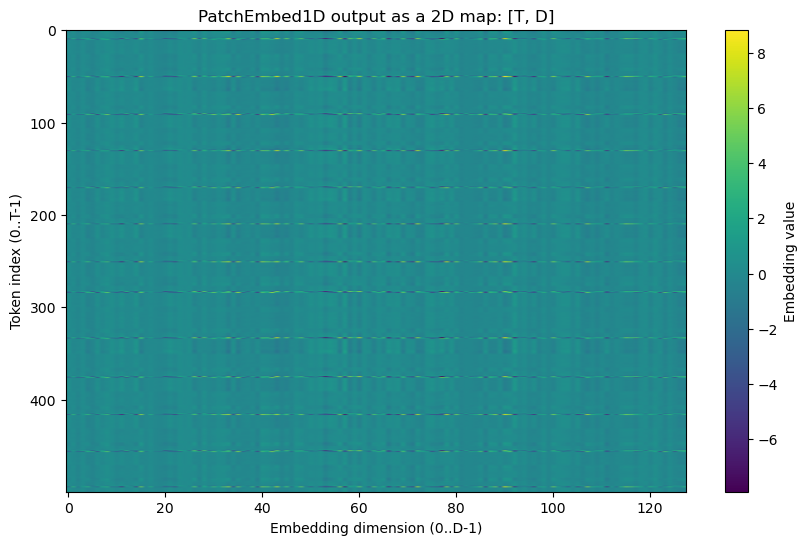

In [53]:
plt.figure(figsize=(10, 6))
plt.imshow(tok.numpy(), aspect="auto")
plt.colorbar(label="Embedding value")
plt.xlabel("Embedding dimension (0..D-1)")
plt.ylabel("Token index (0..T-1)")
plt.title("PatchEmbed1D output as a 2D map: [T, D]")
plt.show()

This figure shows the output of the `PatchEmbed1D` module with shape `[T, D]`:

- Y-axis: token index along time
- X-axis: embedding dimension
- Color: embedding value

Each token (one ECG patch) is mapped to a `D-dimensional` feature vector.

The main purpose of this visualization is to validate the feature generation process:

- Verify that the number of tokens remains unchanged (500)
- Ensure each token is successfully projected into feature space
- Check for abnormal values (e.g., all zeros or exploding values)
- Observe whether tokens at different time positions have distinct representations

From this figure, we can observe that:

- Patch embedding successfully converts waveforms into features
- Token embeddings vary across time
- The model can already distinguish different local segments

### Colored token stitching (interpretability)

Finally, we visualize each token’s waveform segment in a different color and stitch them back into the original ECG (zoomed to the first 20 patches).

This visualization confirms that:

- each token corresponds to a real time segment
- adjacent tokens are contiguous in time
- all tokens together reconstruct the original ECG signal

In [54]:
def plot_ecg_tokens(
    x,
    patch_size,
    num_tokens_show=None,  # None: 画能整除的所有 token
    connect_tokens=True,  # True: 在 token 之间共享端点，避免视觉断裂
    linewidth=2.0,
    figsize=(18, 4),
    title=None,
    pad_ratio=0.05,
    cmap_name="tab20",
):
    """
    Plot ECG signal split into tokens using high-contrast discrete colors.

    Parameters
    ----------
    x : np.ndarray or 1D-like
        1D ECG signal (e.g. x[0].cpu().numpy())
    patch_size : int
        Number of samples per token
    num_tokens_show : int or None
        Number of tokens to show (None = use all full tokens in the signal)
    connect_tokens : bool
        If True, each segment includes the end point so tokens visually connect.
    linewidth : float
        Line width for each token
    figsize : tuple
        Figure size for matplotlib
    title : str or None
        Plot title (auto-generated if None)
    pad_ratio : float
        Vertical padding ratio for y-axis
    cmap_name : str
        Matplotlib colormap name (e.g. "tab20")
    """

    # 转成 1D numpy
    x_np = np.asarray(x).reshape(-1)
    L = len(x_np)

    # 能整除的最大 token 数
    max_tokens = L // patch_size

    if num_tokens_show is None:
        T = max_tokens
    else:
        T = min(num_tokens_show, max_tokens)

    num_samples_show = T * patch_size

    cmap = plt.get_cmap(cmap_name)

    segments = []
    colors = []

    for k in range(T):
        start = k * patch_size
        end = start + patch_size

        if connect_tokens:
            # 包含 end 点，避免 token 间出现视觉空隙
            if end < num_samples_show:
                xs = np.arange(start, end + 1)
                ys = x_np[start : end + 1]
            else:
                xs = np.arange(start, end)
                ys = x_np[start:end]
        else:
            # 不连接，每个 token 独立
            xs = np.arange(start, end)
            ys = x_np[start:end]

        segments.append(np.column_stack([xs, ys]))
        colors.append(cmap(k % 20))  # 高对比离散颜色循环

    lc = LineCollection(segments, colors=colors, linewidths=linewidth)

    fig, ax = plt.subplots(figsize=figsize)
    ax.add_collection(lc)
    ax.set_xlim(0, num_samples_show - 1)

    # y 轴按显示范围自适应 + padding
    visible = x_np[:num_samples_show]
    ymin, ymax = float(visible.min()), float(visible.max())
    pad = pad_ratio * (ymax - ymin + 1e-9)
    ax.set_ylim(ymin - pad, ymax + pad)

    # 自动生成 title
    if title is None:
        if T == max_tokens and num_tokens_show is None:
            title = f"ECG split into tokens (patch_size={patch_size}, tokens={T})"
        else:
            title = (
                f"First {num_samples_show} samples = {T} tokens "
                f"(patch_size={patch_size})"
            )

    ax.set_title(title)
    ax.set_xlabel("Sample index")
    ax.set_ylabel("Amplitude")
    plt.show()

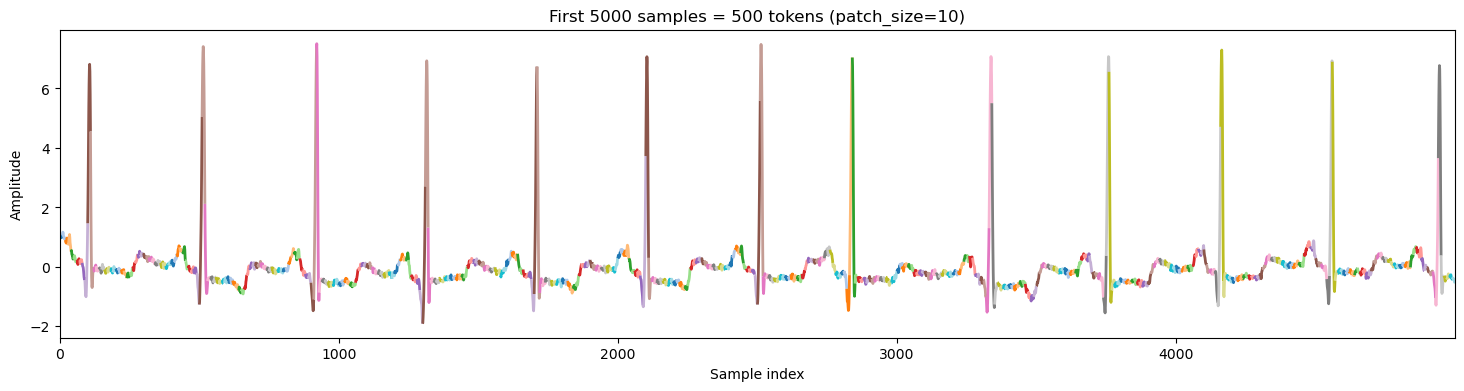

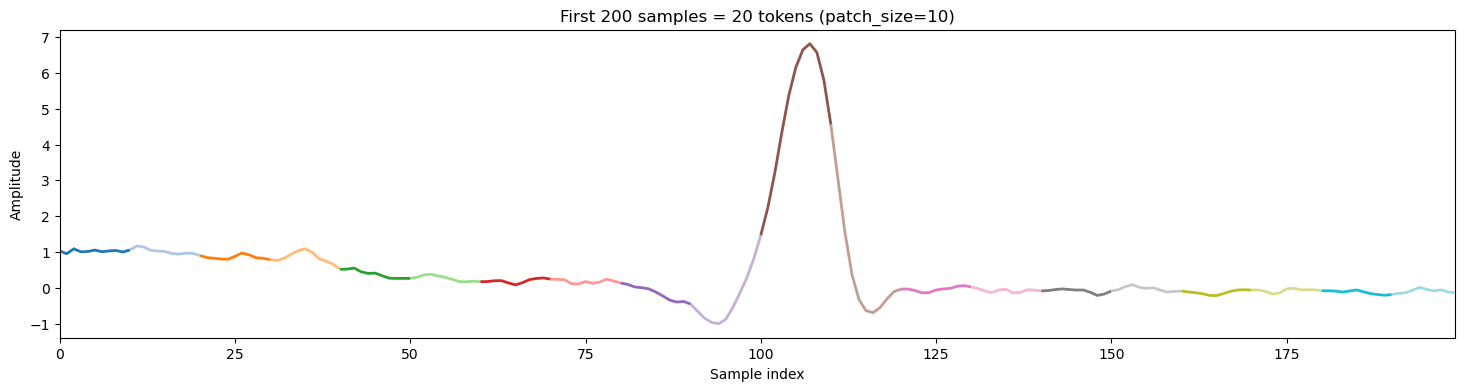

In [55]:
x0 = x[0].detach().cpu().numpy()  # [L]

plot_ecg_tokens(
    x0,
    patch_size=patch_size,
    num_tokens_show=500,
    connect_tokens=True,
    linewidth=2.0,
)

plot_ecg_tokens(
    x0,
    patch_size=patch_size,
    num_tokens_show=20,
    connect_tokens=True,
    linewidth=2.0,
)

In Part 0, we used several visualizations to systematically validate the transformation from raw ECG waveforms to token representations.

* The raw ECG waveform provides a reference, ensuring that all patches and tokens are traceable to the original signal.
* The 2D visualization of `patchify()` confirms that the ECG is split into 500 non-overlapping patches in temporal order, with each patch containing consecutive samples and reasonable value ranges.
* Example patch plots show that each token corresponds to a real local ECG segment, emphasizing the physical meaning of tokens.
* The 2D map of `PatchEmbed1D` outputs verifies that each patch is successfully projected into a D-dimensional feature space while preserving temporal order.
* The token embedding norm over time demonstrates that embeddings vary across tokens, indicating that the patch embedding stage already responds to signal variations without numerical instability.

Overall, these visualizations are not meant for semantic ECG interpretation, but for validating correct data flow, shape consistency, and feature generation, forming a solid foundation for subsequent MAE masking and encoder stages.

## Part 1: Positional Embedding

Token 本身不带时间顺序信息; 如果不显式加入位置信息, 模型无法区分 "第 0 个 token" 和 "第 300 个 token"

In part 0, we got: `tokens: [B, T, D] = [1, 500, 128]`

- ECG is a strict time series
- Order, relative spacing, and rhythm depend on time
- Without position, the model only sees a bag of local segments, not temporal evolution

sinusoidal positional embedding: `tokens = tokens + pos_embedding`

### Step 1: Build / load token embeddings [T, D]

Here we reuse the `tokens` from Part 0 (shape `[B, T, D]`) as the input to positional embedding.

At this stage, tokens contain local content features, but they **do not explicitly encode their position/order**.

In [56]:
# tokens: [B, T, D] from Part 0
tok = tokens[0].detach().cpu()  # [T, D]
T, D = tok.shape
print("tok shape [T, D]:", tok.shape)

tok shape [T, D]: torch.Size([500, 128])


### Step 2: Create sinusoidal positional embedding matrix `PE[T, D]`

Sinusoidal positional embedding generates a D-dimensional vector for each token index $(0...T-1)$.

It is **deterministic** (no learned parameters).

The output is a matrix `PE` with shape `[T, D]`.

In [57]:
import math
import torch


def make_sincos_pe(T: int, D: int, device="cpu"):
    pe = torch.zeros(T, D, device=device)
    pos = torch.arange(0, T, dtype=torch.float32, device=device).unsqueeze(1)  # [T,1]
    div = torch.exp(
        torch.arange(0, D, 2, dtype=torch.float32, device=device)
        * (-math.log(10000.0) / D)
    )
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe  # [T, D]


pe = make_sincos_pe(T, D)  # [T, D]
print("pe shape [T, D]:", pe.shape)
print("pe stats: min =", float(pe.min()), "max =", float(pe.max()))

pe shape [T, D]: torch.Size([500, 128])
pe stats: min = -1.0 max = 1.0


### Step 3: Visualize positional embedding `PE` as a 2D map

We visualize `PE[T, D]` as a 2D map.

This figure is used to check that positional embeddings show a **structured temporal pattern** (not random noise), and that values are in a reasonable range (typically -1 to 1).

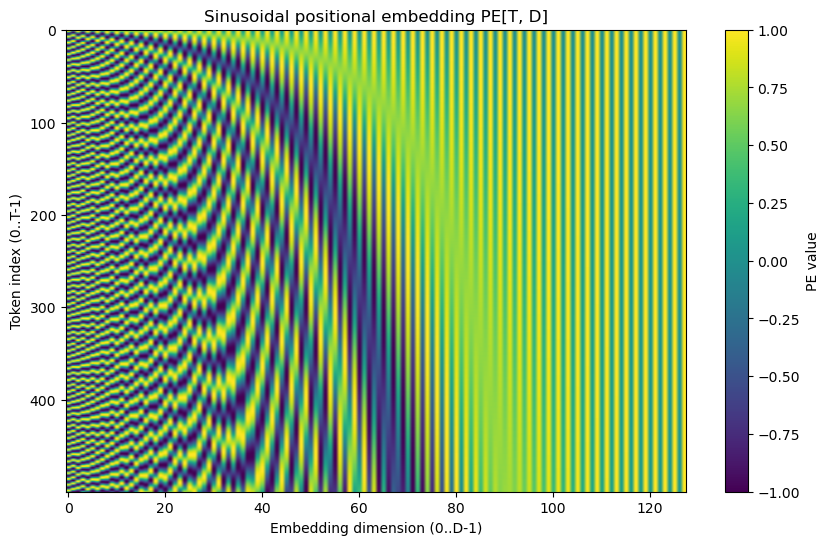

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(pe.numpy(), aspect="auto")
plt.colorbar(label="PE value")
plt.xlabel("Embedding dimension (0..D-1)")
plt.ylabel("Token index (0..T-1)")
plt.title("Sinusoidal positional embedding PE[T, D]")
plt.show()

### Step 4: Add PE to tokens -> `tok_pos = tok + pe`

Using positional embedding is simple: we add `PE` to token embeddings.

Interpretation:

- tokens provide "content"
- PE provides "position"

Their sum is used as the encoder input.

In [59]:
tok_pos = tok + pe  # [T, D]
print("tok_pos shape:", tok_pos.shape)

# Compare basic statistics
print("tok    mean/std:", float(tok.mean()), float(tok.std()))
print("tok+pe mean/std:", float(tok_pos.mean()), float(tok_pos.std()))

tok_pos shape: torch.Size([500, 128])
tok    mean/std: 0.010568072088062763 0.6128634214401245
tok+pe mean/std: 0.2758294939994812 0.8893201351165771


### Step 5: Visualize “before vs after” (difference map)

To see what positional embedding adds, we visualize the difference:

`delta = (tok + pe) - tok = pe`

In theory, the difference map should exactly match `PE` (a strong sanity check).

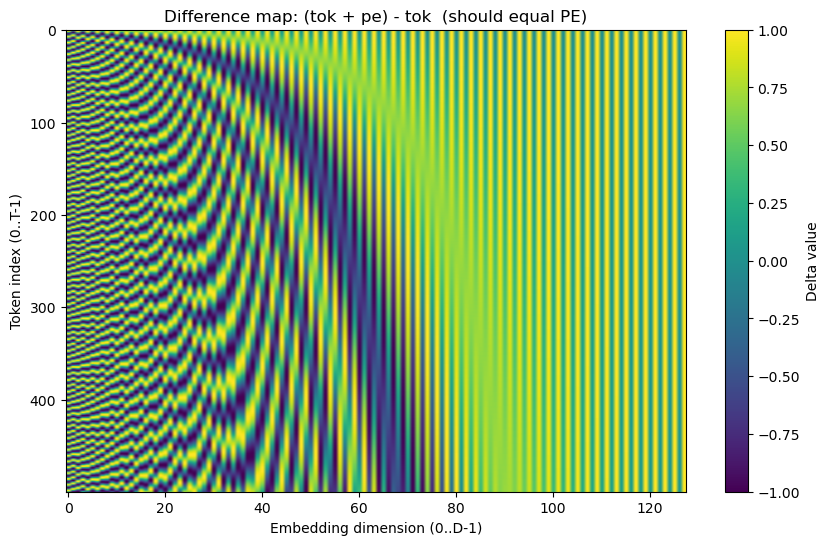

Max |delta - pe| = 4.023313522338867e-07


In [60]:
delta = tok_pos - tok  # should equal pe

plt.figure(figsize=(10, 6))
plt.imshow(delta.numpy(), aspect="auto")
plt.colorbar(label="Delta value")
plt.xlabel("Embedding dimension (0..D-1)")
plt.ylabel("Token index (0..T-1)")
plt.title("Difference map: (tok + pe) - tok  (should equal PE)")
plt.show()

# Numerical check
max_abs_err = (delta - pe).abs().max().item()
print("Max |delta - pe| =", max_abs_err)

### Step 6: Shuffling tokens destroys order without PE

We run a simple experiment: randomly shuffle token order.

- Without positional information, a set of token vectors does not mathematically encode order.
- With PE, shuffling changes the token-position alignment, meaning order is explicitly encoded.

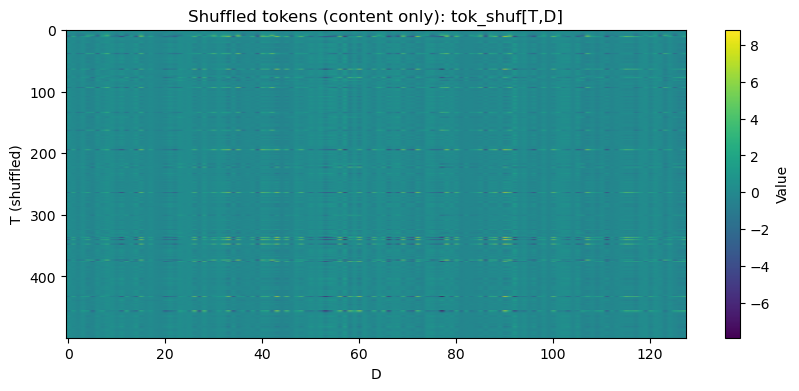

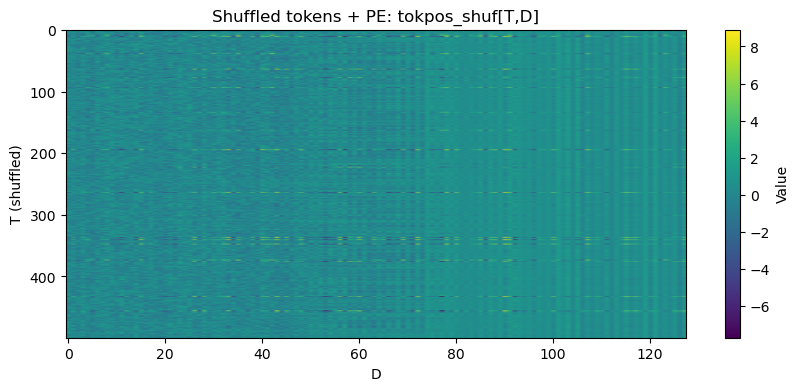

In [61]:
perm = torch.randperm(T)
tok_shuf = tok[perm]  # shuffled tokens (content only)
tokpos_shuf = tok_pos[perm]  # shuffled tokens+position

# Visualize shuffled token embeddings (content only)
plt.figure(figsize=(10, 4))
plt.imshow(tok_shuf.numpy(), aspect="auto")
plt.colorbar(label="Value")
plt.title("Shuffled tokens (content only): tok_shuf[T,D]")
plt.xlabel("D")
plt.ylabel("T (shuffled)")
plt.show()

# Visualize shuffled tokens+position
plt.figure(figsize=(10, 4))
plt.imshow(tokpos_shuf.numpy(), aspect="auto")
plt.colorbar(label="Value")
plt.title("Shuffled tokens + PE: tokpos_shuf[T,D]")
plt.xlabel("D")
plt.ylabel("T (shuffled)")
plt.show()

Positional embedding injects order information into tokens. Since token embeddings alone do not encode “which token comes first”, we generate a deterministic sinusoidal `PE[T, D]` and add it to tokens before feeding them into the encoder. 

The visualization shows a structured periodic pattern with values bounded in [-1, 1]. The difference map validates the implementation (`(tok+pe)-tok = PE`). 

A shuffling experiment further illustrates that without PE, token order is not explicitly represented, while adding PE binds content to position, making order available to the model.

When tokens are shuffled, content-only embeddings look almost unchanged, meaning order is not encoded.

After adding positional embedding, clear structured patterns appear, showing that positional information is explicitly injected into the token sequence.

## Part 2: Masking

If the model sees the full ECG and reconstructs it, the task is too easy: The model may just learn to copy the input

`Masking` forces the model to:

- use context
- exploit temporal dependencies
- learn rhythm and morphology consistency

The goal of masking is not to randomly drop data, but to **force the model to understand ECG structure under incomplete information**.

If the model can reconstruct missing parts from partial input, it indicates that it has learned temporal and rhythm structure rather than memorizing waveforms.

### Step 1: Input to masking

In part 1, we got `tokens: [B, T, D]`

- `B`: batch size
- `T`: number of tokens
- `D`: D-dimensional embedding

At this point, each token contains `local content features`, and positional embedding has already injected `order information`.

In [62]:
tok = tokens.detach().cpu()
B, T, D = tok.shape
print("tokens shape:", tok.shape)

tokens shape: torch.Size([1, 500, 128])


### Step 2: Apply random masking

We apply `MAE-style random masking`:

- Generate a random noise score for every token.
- Sort tokens by noise.
- Keep the first `T_keep = T * (1 - mask_ratio)` tokens as visible.
- The remaining tokens are `masked` (removed from encoder input).

Output:

- `x_keep`: visible tokens for the encoder, shape `[B, T_keep, D]`
- `mask`: binary mask, shape `[B, T]` (1 = masked, 0 = visible)
- `ids_restore`: indices to restore original order later (for the decoder)
- `ids_keep`: indices of kept tokens


In [63]:
from models.mini_mae_v2 import random_masking_with_ids

mask_ratio = 0.6

x_keep, mask, ids_restore, ids_keep = random_masking_with_ids(tok, mask_ratio)

print("Visible tokens shape:", x_keep.shape)
print("Mask shape:", mask.shape)
print("Actual masked ratio:", mask.sum().item() / mask.numel())

Visible tokens shape: torch.Size([1, 200, 128])
Mask shape: torch.Size([1, 500])
Actual masked ratio: 0.6


### Step 3: Visualize the mask map

This plot shows which tokens are visible and which are masked.

- White = masked token
- Black = visible token

Important: the masking is random and scattered, not one continuous block.

This prevents the model from solving reconstruction by simple local copying, and forces it to use broader context.

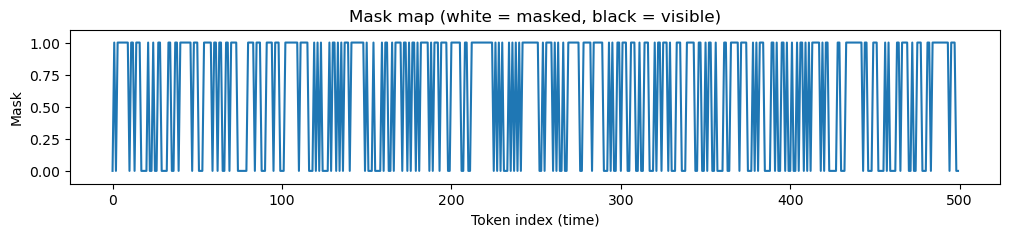

In [64]:
import matplotlib.pyplot as plt

m0 = mask[0].detach().cpu().numpy()  # [T]
plt.figure(figsize=(12, 2))
plt.plot(m0)
plt.ylim(-0.1, 1.1)
plt.title("Mask map (white = masked, black = visible)")
plt.xlabel("Token index (time)")
plt.ylabel("Mask")
plt.show()

### Step 4: What the encoder actually sees

`x_keep: [B, T_keep, D]`

The encoder never sees `masked tokens`.
Its input is only the visible subset `x_keep`.

This is a key MAE design choice:

- The encoder learns a `compact representation` from incomplete information.
- The decoder is responsible for filling in missing details during reconstruction.

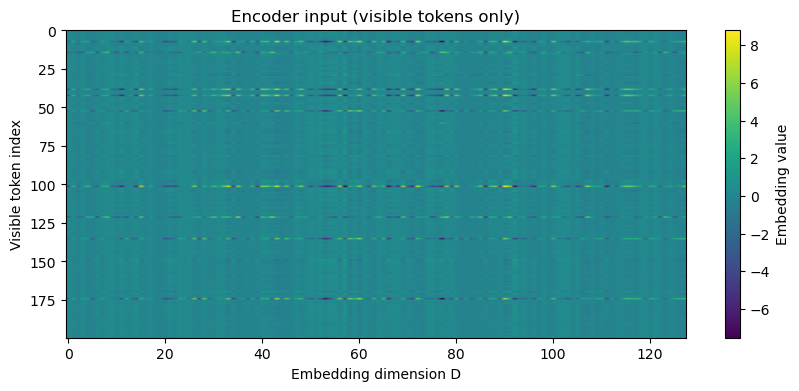

In [65]:
plt.figure(figsize=(10, 4))
plt.imshow(x_keep[0].numpy(), aspect="auto")
plt.colorbar(label="Embedding value")
plt.xlabel("Embedding dimension D")
plt.ylabel("Visible token index")
plt.title("Encoder input (visible tokens only)")
plt.show()

### Step 5: Prepare decoder input

The decoder expects a full-length sequence of `T` tokens.

To construct this input:

- Create a shared `mask_token` embedding.
- Concatenate visible tokens with `mask_tokens` to reach length `T`.
- Use `ids_restore` to put tokens back into the original time order.

After this step, `dec_tokens` has shape `[B, T, D]`:

- visible positions contain real token embeddings
- masked positions contain the placeholder `mask_token`

In [66]:
mask_token = torch.zeros(1, 1, D)  # placeholder; your model uses a learned mask_token

B, T_keep, D = x_keep.shape
mask_tokens = mask_token.expand(B, T - T_keep, D)

# Concatenate (still in shuffled order)
dec_tokens_ = torch.cat([x_keep, mask_tokens], dim=1)

# Restore original order
dec_tokens = torch.gather(
    dec_tokens_, dim=1, index=ids_restore.unsqueeze(-1).expand(-1, -1, D)
)

print("Decoder input shape [B, T, D]:", dec_tokens.shape)

Decoder input shape [B, T, D]: torch.Size([1, 500, 128])


### Step 6: Visualize decoder input structure

This visualization shows the structure of the decoder input.

- Some rows correspond to `real visible tokens`
- Some rows correspond to `mask tokens (placeholders)`

The decoder’s job is to use visible context to predict the missing patches at masked positions.

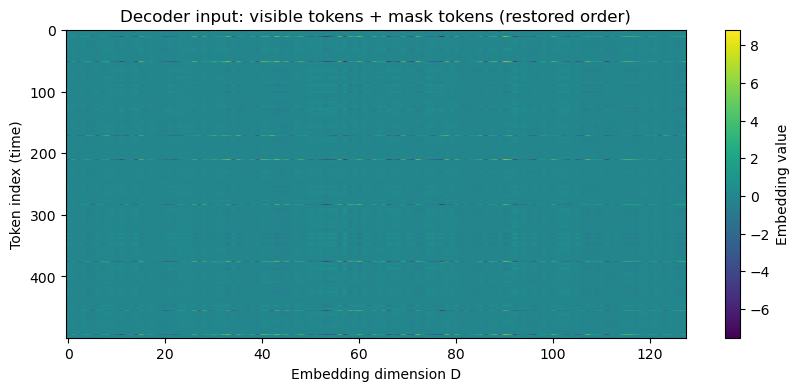

In [67]:
plt.figure(figsize=(10, 4))
plt.imshow(dec_tokens[0].numpy(), aspect="auto")
plt.colorbar(label="Embedding value")
plt.xlabel("Embedding dimension D")
plt.ylabel("Token index (time)")
plt.title("Decoder input: visible tokens + mask tokens (restored order)")
plt.show()

### Step 7: Why loss is computed only on masked tokens

In MAE, the reconstruction loss is computed `only on masked positions`:

- If we also penalize visible positions, the model can minimize loss by simply copying visible inputs.
- By focusing loss on masked tokens, we force the model to `infer missing content from context`, which encourages learning useful representations.

In [68]:
# Example loss logic (matches your mae_loss_masked idea)
# pred_patches: [B, T, N*P]
# target_patches: [B, T, N*P]
# mask: [B, T] (1 = masked, 0 = visible)

# loss_per = (pred_patches - target_patches).pow(2).mean(dim=-1)  # [B, T]
# loss = (loss_per * mask).sum() / (mask.sum() + 1e-8)

# print("Masked MSE loss:", float(loss))

## Part 3: Encoder - Learning contextual ECG representations

### Step 1: What goes into the encoder?

After Part 2 (masking), the encoder receives `only visible tokens`.

- Input: `x_keep: [B, T_keep, D]`

These tokens:

- come from different time locations
- are not contiguous
- already contain positional information

The encoder must learn a meaningful representation `from incomplete and scattered ECG context`.

In [69]:
# x_keep from Part 2
print("Encoder input shape [B, T_keep, D]:", x_keep.shape)

Encoder input shape [B, T_keep, D]: torch.Size([1, 200, 128])


### Step 2: Structure of one Transformer encoder block

Each encoder block in this model has the following structure (Pre-LN):

- LayerNorm
- Multi-head self-attention
- Residual connection
- LayerNorm
- Feed-forward network (MLP)
- Residual connection

In [70]:
import torch
import torch.nn as nn


class TransformerBlock(nn.Module):
    def forward(self, x):
        y = self.ln1(x)
        y, _ = self.attn(y, y, y)
        x = x + y

        y = self.ln2(x)
        y = self.mlp(y)
        x = x + y
        return x

### Step 3: What does self-attention mean for ECG tokens?

Self-attention allows `each token to interact with all other visible tokens`.

For ECG, this means, A token corresponding to one local waveform segment can:

- attend to other beats
- attend to rhythm context
- attend to distant but related signal patterns

Importantly:

- Attention is `not restricted by time distance`
- Tokens can exchange information even if they are far apart in time

This is particularly useful for ECG, where:

- rhythm patterns span multiple beats
- local morphology depends on broader context

### Step 4: Why attention is better than pure CNN here

Compared to CNNs:

- CNNs use `local receptive fields`
- Transformers use `global receptive fields from the first layer`

In the MAE encoder:

- Even with many tokens masked
- Each visible token can still attend to all other visible tokens

This allows the encoder to build `global, context-aware representations` from partial ECG signals.

### Step 5: Run the encoder blocks step by step

We now pass the visible tokens through the encoder blocks one by one.

At each layer:

- token representations become more contextual
- information is gradually integrated across tokens

We can inspect how representations evolve.

In [71]:
# Assume `model.encoder` is your list of TransformerBlock
h = x_keep.clone()

for i, blk in enumerate(model.encoder):
    h = blk(h)
    print(f"After encoder block {i}: shape =", h.shape)

After encoder block 0: shape = torch.Size([1, 200, 128])
After encoder block 1: shape = torch.Size([1, 200, 128])
After encoder block 2: shape = torch.Size([1, 200, 128])
After encoder block 3: shape = torch.Size([1, 200, 128])


### Step 6: Compare encoder input vs encoder output

To understand the effect of the encoder, we compare:

- Input to encoder (`x_keep`)
- Output from encoder (`h`)

We are not looking for semantic meaning yet, but for:

- change in representation
- increased structure
- contextual mixing

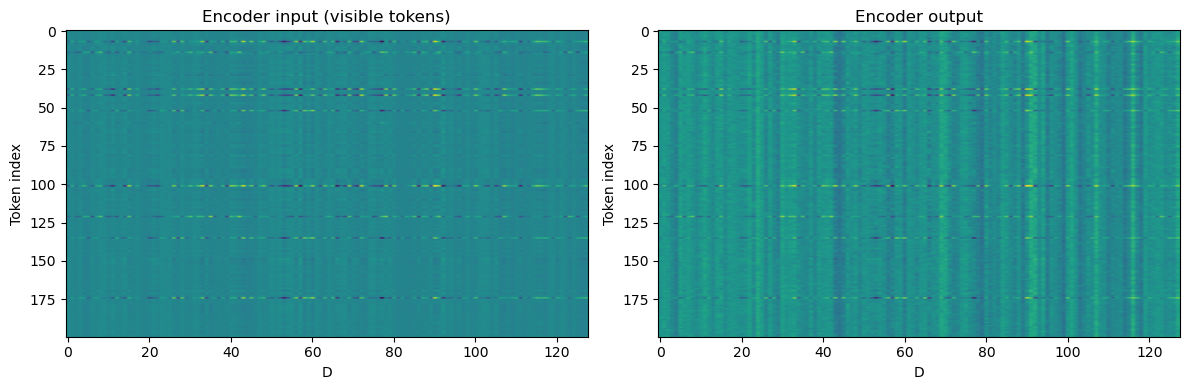

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(x_keep[0].numpy(), aspect="auto")
plt.title("Encoder input (visible tokens)")
plt.xlabel("D")
plt.ylabel("Token index")

plt.subplot(1, 2, 2)
plt.imshow(h[0].detach().numpy(), aspect="auto")
plt.title("Encoder output")
plt.xlabel("D")
plt.ylabel("Token index")

plt.tight_layout()
plt.show()

### Step 8: What the encoder is learning (and what it is not)

At this stage, the encoder is `not` directly learning diagnoses or labels.

Instead, it is learning:

- consistency across beats
- temporal dependencies
- rhythm-level structure
- relationships between distant ECG segments

This representation will later be:

- reused for downstream tasks
- fine-tuned for classification
- evaluated for generalization

The encoder is the core of representation learning in MAE.

Through self-attention and feed-forward layers, it integrates information across scattered ECG tokens and builds context-aware representations.

By operating on masked and incomplete inputs, the encoder is encouraged to learn robust temporal structure rather than memorizing local waveforms.

## Part 4: Decoder and Reconstruction

### Step 1: What is the role of the decoder?

In a Masked Autoencoder, the `decoder is not the main model`.

Its purpose is not to learn a strong representation, but to provide a reconstruction task that guides the encoder.

Key roles of the decoder:

- Receive a full-length token sequence:
  - real tokens at visible positions
  - mask_token at masked positions
- Predict the `raw signal patches` at masked locations
- Provide a learning signal (loss) for pretraining

After pretraining, the `decoder is usually discarded`, and only the encoder is reused.

### Step 2: Decoder input structure

Before entering the decoder, we construct its input as follows:

- Take encoder output `h` (visible tokens only)
- Insert a shared `mask_token` for masked positions
- Restore original token order using `ids_restore`

The resulting decoder input has shape: `dec_tokens: [B, T, D]`

This sequence mixes:

- contextualized visible tokens
- placeholder tokens indicating missing content

In [73]:
# dec_tokens from Part 2
print("Decoder input shape [B, T, D]:", dec_tokens.shape)

Decoder input shape [B, T, D]: torch.Size([1, 500, 128])


### Step 3: Passing through the decoder blocks

The decoder consists of several Transformer blocks, similar in structure to the encoder but typically:

- shallower (fewer layers)
- lower capacity

The decoder processes `dec_tokens` and produces `context-aware representations` at all token positions, including masked ones.

In [74]:
h_dec = dec_tokens.clone()

for i, blk in enumerate(model.decoder):
    h_dec = blk(h_dec)
    print(f"After decoder block {i}: shape =", h_dec.shape)

After decoder block 0: shape = torch.Size([1, 500, 128])
After decoder block 1: shape = torch.Size([1, 500, 128])


### Step 5: Ground truth patches

The reconstruction target is obtained using the same `patchify()` operation applied to the original ECG signal.

- Target shape: `[B, T, N * P]`

There is a `one-to-one correspondence` between:

- predicted patch `pred_patches[:, t]`
- ground truth patch `target_patches[:, t]`

In [75]:
print("Target patches shape:", target_patches.shape)

Target patches shape: torch.Size([1, 500, 10])


### Step 6: Reconstruction loss (masked only)

The MAE reconstruction loss is computed only on masked tokens.

why?

- Visible tokens already contain the answer
- Penalizing visible tokens would allow trivial copying
- Masked-only loss forces true inference from context

In [76]:
# loss_per_patch = (pred_patches - target_patches).pow(2).mean(dim=-1)  # [B, T]
# loss = (loss_per_patch * mask).sum() / (mask.sum() + 1e-8)

# print("Masked reconstruction loss:", float(loss))

### Step 7: Visualize reconstruction (masked vs visible)

To interpret reconstruction quality, it is important to:

- focus on masked regions
- avoid over-interpreting perfect reconstruction

We compare:

- original ECG
- reconstructed ECG
- masked regions highlighted

In [77]:
# # Reconstruct full signal from patches
# B, T, NP = pred_patches.shape
# P = model.patch_size

# recon = pred_patches.view(B, T, P).reshape(B, -1)
# orig = x.detach().cpu().view(B, -1)

# # Build mask at sample level
# mask_samples = mask.repeat_interleave(P, dim=1)

# # Plot a short segment
# L_show = 500

# plt.figure(figsize=(14, 4))
# plt.plot(orig[0, :L_show], label="Original", linewidth=1)
# plt.plot(recon[0, :L_show], label="Reconstructed", linewidth=1)

# # Highlight masked regions
# masked_idx = mask_samples[0, :L_show].bool()
# plt.scatter(
#     torch.arange(L_show)[masked_idx],
#     orig[0, :L_show][masked_idx],
#     color="red",
#     s=6,
#     label="Masked samples",
# )

# plt.legend()
# plt.title("ECG reconstruction (masked regions highlighted)")
# plt.xlabel("Sample index")
# plt.ylabel("Amplitude")
# plt.show()

### Step 8: How to interpret reconstruction

A good MAE reconstruction does not mean:

- perfect waveform recovery
- clinically accurate ECG generation

Instead, it indicates that the encoder has learned:

- consistent beat morphology
- temporal smoothness
- rhythm-level regularities

Small reconstruction errors are expected and even desirable.

Overly perfect reconstruction may indicate:

- information leakage
- masking too weak
- insufficient task difficulty

The decoder provides a reconstruction task that guides representation learning.

By predicting masked ECG patches from partial context and computing loss only on masked regions, MAE encourages the encoder to learn robust temporal and structural features rather than memorizing raw waveforms.

Reconstruction quality should be interpreted as a proxy for learned structure, not as a final modeling goal.

## Part 5: From MAE Encoder to Downstream ECG Classification

### Step 1: Why downstream tasks are needed

Pretraining alone does not directly solve a clinical task. The purpose of MAE pretraining is to learn a general ECG representation that can be reused for downstream tasks.

Downstream tasks allow us to evaluate whether the learned representation:

- generalizes to labeled datasets
- captures meaningful ECG structure
- improves data efficiency compared to training from scratch

In this work, we focus first on ECG classification, which aligns with the original goal of the FYP.

### Step 2: What part of the MAE model is reused?

After MAE pretraining:

- the `encoder` is reused
- the `decoder and reconstruction head` are discarded

This is because:

- the encoder learns contextual representations
- the decoder is only a training scaffold for reconstruction

### Step 3: What is the encoder output used for classification?

The encoder outputs a sequence of token embeddings: `H: [B, T, D]`

To perform classification, this sequence must be converted into a `fixed-length vector`.

Common strategies include:

- `Global average pooling` over tokens
- `Using a special token` (e.g. [CLS], optional)
- `Attention pooling` (more advanced)

In this project, global average pooling is a simple and effective starting point.

### Step 4: Adding a classification head

A lightweight classification head is attached on top of the encoder representation.

Typically:

- one or two linear layers
- optional dropout
- task-specific output dimension

Example:

- beat classification -> number of beat classes
- rhythm classification -> number of rhythm types

### Step 5: Input length: does it have to be 10 seconds?

Using 10-second inputs during pretraining does `not` force downstream tasks to use exactly 10 seconds.

There are two common downstream strategies:
:
`Strategy A — Keep 10-second inputs`:

- Input: 10 s ECG segments
- Output: one prediction per segment
- Suitable for:
  - rhythm classification
  - coarse arrhythmia detection

This strategy fully leverages the context learned during pretraining.

`Strategy B — Beat-level classification using context`:

- Input: 10 s ECG centered around a target beat
- Label: class of the `center beat`
- Other beats provide contextual information

This allows:

- beat-level labels
- rhythm-aware classification
- reuse of the pretrained encoder without architectural changes

### Step 6: Sliding window vs center-beat labeling

Two practical approaches exist for beat-level inference:

`Sliding window`:

- run the model on overlapping 10 s windows
- aggregate predictions for each beat
- higher computational cost

`Center-beat labeling`:

- one window → one beat label
- simpler supervision
- commonly used in ECG literature

For this project, center-beat labeling is a reasonable first choice.

### Step 7: Training strategy for downstream tasks

Typical fine-tuning strategies include:

`Freeze encoder, train head only`:

- tests representation quality
- fast and stable

`Fine-tune entire model`:

- potentially better performance
- higher risk of overfitting

A recommended workflow:

- start with frozen encoder
- then allow partial or full fine-tuning

### Step 8: What does good downstream performance mean?

Improved downstream performance indicates that the pretrained encoder has learned:

- reusable ECG features
- rhythm-aware representations
- morphology consistency across beats

However, downstream accuracy should be interpreted together with:

- dataset size
- label quality
- task difficulty

The goal is not to achieve SOTA, but to demonstrate effective representation transfer.

MAE pretraining produces a general ECG encoder that can be reused for multiple downstream tasks.

By attaching a lightweight classification head and selecting an appropriate input strategy, the pretrained encoder can support both segment-level and beat-level ECG classification.

Downstream evaluation validates whether the learned representations capture clinically relevant ECG structure.